# Regression analysis of car sales

This notebook involves data preparation and training of a number of regression models for comparison. The dataset is a car sales dataset, with the purpose being to predict accurate sales prices given appropriate features.


### Imports

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import seaborn as sns
sns.set()

### Load data and initial look at the data

The dataset consists of 8 features and slightly over 4000 rows of data. There is a mix of categorical and numerical features describing both the form (Body, Model...) and condition (Year, Mileage...) of each car.

In [2]:
raw_data = pd.read_csv('Car Sales.csv')
raw_data.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4


In [3]:
raw_data.count()

Brand           4345
Price           4173
Body            4345
Mileage         4345
EngineV         4195
Engine Type     4345
Registration    4345
Year            4345
Model           4345
dtype: int64

### Missing values
There are some missing values in the `Price` and `EngineV` columns. As they account for a small amount of the data, they will be removed.

In [4]:
raw_data.isnull().sum()

Brand             0
Price           172
Body              0
Mileage           0
EngineV         150
Engine Type       0
Registration      0
Year              0
Model             0
dtype: int64

In [5]:
data_no_mv = raw_data.dropna(axis=0)
#data_no_price_mv = raw_data[~raw_data['Price'].isnull()]

In [6]:
data_no_mv.isnull().sum()

Brand           0
Price           0
Body            0
Mileage         0
EngineV         0
Engine Type     0
Registration    0
Year            0
Model           0
dtype: int64

In [7]:
data_no_mv.count()

Brand           4025
Price           4025
Body            4025
Mileage         4025
EngineV         4025
Engine Type     4025
Registration    4025
Year            4025
Model           4025
dtype: int64

### Exploratory Data Analysis
A pair plot is used to check the relationships between features and look at outliers.

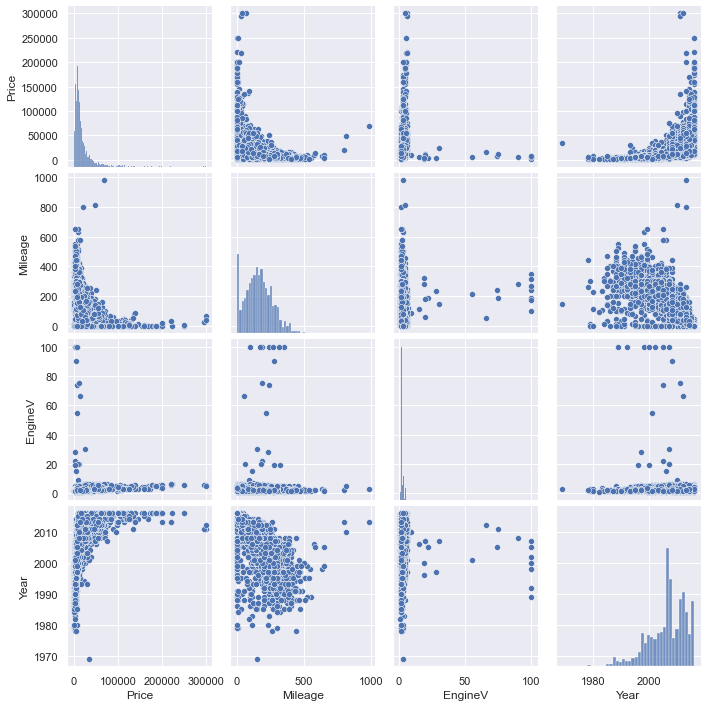

In [8]:
sns.pairplot(data_no_mv)

In [9]:
data_no_mv.describe()

,Price,Mileage,EngineV,Year
count,4025.000000,4025.000000,4025.000000,4025.000000
mean,19552.308065,163.572174,2.764586,2006.379627
std,25815.734988,103.394703,4.935941,6.695595
min,600.000000,0.000000,0.600000,1969.000000
25%,6999.000000,90.000000,1.800000,2003.000000
50%,11500.000000,158.000000,2.200000,2007.000000
75%,21900.000000,230.000000,3.000000,2012.000000
max,300000.000000,980.000000,99.990000,2016.000000


It looks like there are quite a few outliers in some of the variables. There are some clearly nonsensical values in the EngineV data, as engine volumes are typically no higher than 6.5l. We can safely remove values above this.

We will also trim ~1% of the data from the `Price`, `Year` and `Mileage` columns to reduce outliers.

In [10]:
data_no_engine_outliers = data_no_mv[data_no_mv['EngineV']<6.5]

In [11]:
q = data_no_engine_outliers['Price'].quantile(0.99)
data_1 = data_no_engine_outliers[data_no_engine_outliers['Price']<q]
q = data_1['Mileage'].quantile(0.99)
data_2 = data_1[data_1['Mileage']<q]
q = data_2['Year'].quantile(0.01)
data_3 = data_2[data_2['Year']>q]

Price seems to have an exponential tail and an exponential relationship with Mileage and Year so we can take the log transform of price to get more normal distribution in price and linear relationships.

In [12]:
log_price = np.log(data_3['Price'])

In [13]:
data_log_price = data_3.copy()
data_log_price['log_Price'] = log_price
data_log_price.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model,log_Price
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320,8.342840
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212,8.974618
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500,9.495519
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7,10.043249
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4,9.814656


In [14]:
data_log_price = data_log_price.drop('Price', axis=1)
data_log_price.head()

,Brand,Body,Mileage,EngineV,Engine Type,Registration,Year,Model,log_Price
0,BMW,sedan,277,2.0,Petrol,yes,1991,320,8.342840
1,Mercedes-Benz,van,427,2.9,Diesel,yes,1999,Sprinter 212,8.974618
2,Mercedes-Benz,sedan,358,5.0,Gas,yes,2003,S 500,9.495519
3,Audi,crossover,240,4.2,Petrol,yes,2007,Q7,10.043249
4,Toyota,crossover,120,2.0,Petrol,yes,2011,Rav 4,9.814656


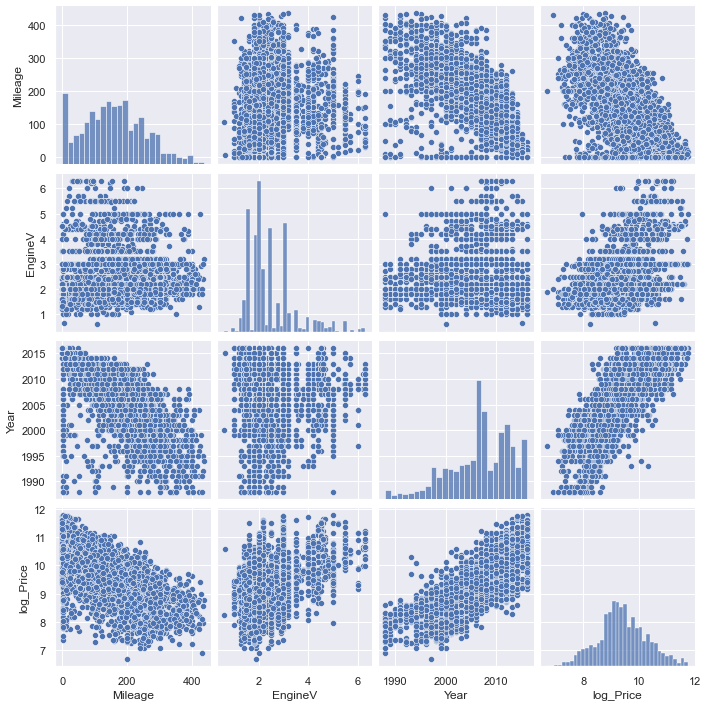

In [15]:
sns.pairplot(data_log_price)

These relationships look a lot more linear and the `log_price` is reasonably normally distributed.

### Define regression pipeline

First we label the numeric and categorical features, then define how they will be preprocessed before combining the preprocessing steps with the model in a pipeline. 

In [16]:
#define a custom switcher class that can take any estimator

from sklearn.base import BaseEstimator
class RegSwitcher(BaseEstimator):

    def __init__(
        self, 
        estimator = LinearRegression(),
    ):
        """
        A Custom BaseEstimator that can switch between estimators.
        :param estimator: sklearn object - The regressor
        """ 

        self.estimator = estimator


    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self


    def predict(self, X, y=None):
        return self.estimator.predict(X)


    def score(self, X, y):
        return self.estimator.score(X, y)

In [17]:
# make a list of estimators and their parameters

params = [
    {
        'reg__estimator': [LinearRegression()]
    },
    {
        'reg__estimator': [GradientBoostingRegressor()]
    },
    {
        'reg__estimator': [KNeighborsRegressor()]
        
    },
    {
        'reg__estimator': [RandomForestRegressor()]
    },
]

In [18]:
#define which columns contain numeric or categorical features
numeric_features = ['Year', 'Mileage', 'EngineV']
categorical_features = ['Brand', 'Body', 'Engine Type', 'Registration', 'Model']

In [19]:
#Normalise numeric features with StandardScaler() and one-hot encode categorical features
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

In [20]:
preprocessor = ColumnTransformer(
        transformers =[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

In [21]:
reg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('reg', RegSwitcher())])

### Model training and results

Split the data into training and test sets (80 and 20% of the data, respectively) then train the model using the training set.

In [22]:
X = data_log_price.drop('log_Price', axis=1)
y = data_log_price['log_Price']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

In [24]:
#y_hat = reg.predict(X_train)

In [102]:
gscv = GridSearchCV(reg, params, cv=10, n_jobs=2, verbose=3, scoring='neg_mean_squared_error')
gscv.fit(X_train, y_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Year',
                                                                          'Mileage',
                                                                          'EngineV']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Brand',
                                                                          'Body',
                                                                          'Engine '
                                                         

In [103]:
gscv_results = pd.DataFrame(gscv.cv_results_)
gscv_results.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg__estimator,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
3,4.526356,0.024821,0.019002,0.000444,RandomForestRegressor(),{'reg__estimator': RandomForestRegressor()},-0.044392,-0.062952,-0.050685,-0.045269,-0.059604,-0.051214,-0.040570,-0.046944,-0.052868,-0.061524,-0.051602,0.007276,1
1,0.242888,0.001722,0.006301,0.000458,GradientBoostingRegressor(),{'reg__estimator': GradientBoostingRegressor()},-0.049767,-0.067559,-0.053438,-0.055426,-0.059079,-0.057363,-0.049267,-0.051417,-0.057884,-0.065126,-0.056633,0.005830,2
0,0.050911,0.001301,0.005602,0.000664,LinearRegression(),{'reg__estimator': LinearRegression()},-0.047181,-0.066876,-0.059651,-0.058793,-0.056885,-0.061327,-0.053416,-0.048792,-0.054936,-0.062621,-0.057048,0.005822,3
2,0.012103,0.000300,0.032908,0.000300,KNeighborsRegressor(),{'reg__estimator': KNeighborsRegressor()},-0.069312,-0.080686,-0.087040,-0.080658,-0.096895,-0.081116,-0.071167,-0.067292,-0.089198,-0.080324,-0.080369,0.008799,4


In [111]:
scores = gscv_results.drop(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'mean_test_score', 'std_test_score', 'rank_test_score', 'params'], axis=1)
scores = scores.set_index('param_reg__estimator').T
scores

param_reg__estimator,LinearRegression(),GradientBoostingRegressor(),KNeighborsRegressor(),RandomForestRegressor()
split0_test_score,-0.047181,-0.049767,-0.069312,-0.044392
split1_test_score,-0.066876,-0.067559,-0.080686,-0.062952
split2_test_score,-0.059651,-0.053438,-0.087040,-0.050685
split3_test_score,-0.058793,-0.055426,-0.080658,-0.045269
split4_test_score,-0.056885,-0.059079,-0.096895,-0.059604
split5_test_score,-0.061327,-0.057363,-0.081116,-0.051214
split6_test_score,-0.053416,-0.049267,-0.071167,-0.040570
split7_test_score,-0.048792,-0.051417,-0.067292,-0.046944
split8_test_score,-0.054936,-0.057884,-0.089198,-0.052868
split9_test_score,-0.062621,-0.065126,-0.080324,-0.061524


In [112]:
scores.columns

Index([         LinearRegression(), GradientBoostingRegressor(),
             KNeighborsRegressor(),     RandomForestRegressor()],
      dtype='object', name='param_reg__estimator')

[Text(0, 0, 'LinearRegression()'),
 Text(1, 0, 'GradientBoostingRegressor()'),
 Text(2, 0, 'KNeighborsRegressor()'),
 Text(3, 0, 'RandomForestRegressor()')]

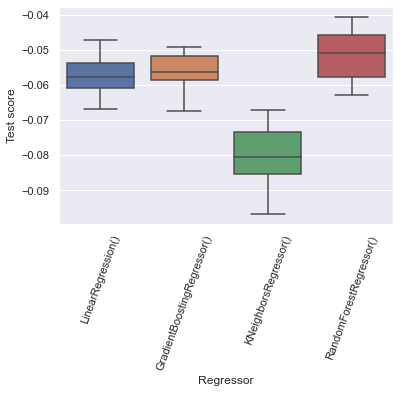

In [113]:
ax = sns.boxplot(data = scores)
ax.set(xlabel='Regressor', ylabel='Test score')
ax.set_xticklabels(scores.columns,rotation=70)

The randon forest regressor performs best, though performance is similar for all execpt the K-Neighbours regressor, which performs markedly worse.

### Training the final model
We will train a final model using the Random Forest regressor on the full training set.

In [117]:
final_model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('reg', RandomForestRegressor())])
final_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Year', 'Mileage',
                                                   'EngineV']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Brand', 'Body',
                                                   'Engine Type',
                                                   'Registration',
                                                   'Model'])])),
                ('reg', RandomForestRegressor())])

In [141]:
final_model.score(X_train, y_train)

0.9905938065309937

In [121]:
y_hat = final_model.predict(X_train)
y_hat

array([11.37246289,  9.16370309,  9.37114722, ...,  9.35336345,
        7.41908456,  8.66541085])

In [143]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_hat, y_train)

0.007176631128292002

In [144]:
y_hat_test = final_model.predict(X_test)

In [145]:
mean_squared_error(y_hat_test, y_test)

0.053740310516249404

There is a noticable increase in the mean squared error between the training and test sets, possible suggesting the model is overfitting.

### Plotting residuals

For the training data, the residuals seem well behaved, and are nicely normally distributed. 

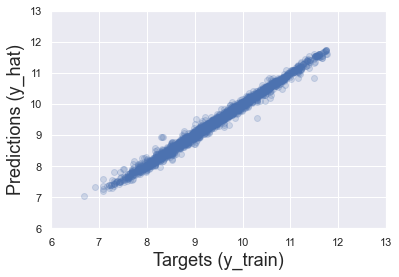

In [122]:
plt.scatter(y_train, y_hat, alpha=0.2)
plt.xlabel('Targets (y_train)',size=18)
plt.ylabel('Predictions (y_hat)',size=18)
plt.xlim(6,13)
plt.ylim(6,13)
plt.show()

Text(0.5, 1.0, 'Residuals PDF')

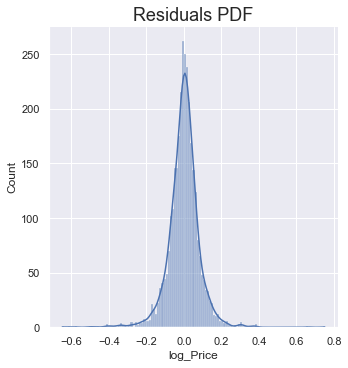

In [123]:
sns.displot(y_train - y_hat, kde=True)
plt.title("Residuals PDF", size=18)

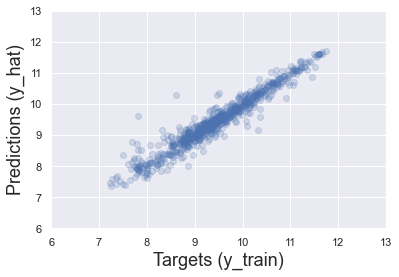

In [162]:
plt.scatter(y_test, y_hat_test, alpha=0.2)
plt.xlabel('Targets (y_train)',size=18)
plt.ylabel('Predictions (y_hat)',size=18)
plt.xlim(6,13)
plt.ylim(6,13)
plt.show()

Text(0.5, 1.0, 'Residuals PDF')

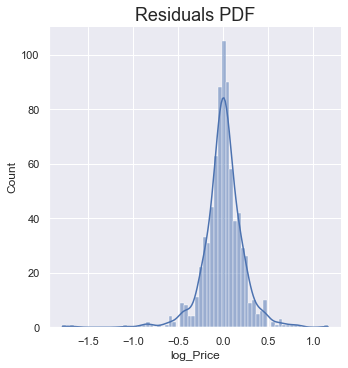

In [163]:
sns.displot(y_test - y_hat_test, kde=True)
plt.title("Residuals PDF", size=18)

By comparison, the model seems to struggle predicting lower priced cars on unseen test data.

### Feature importances

In [124]:
final_cols = final_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names(categorical_features)
final_cols = np.append(numeric_features, final_cols)

In [153]:
reg_summary = pd.DataFrame(final_cols, columns=['Features'])
reg_summary['Feature importance'] = final_model.named_steps['reg'].feature_importances_
with pd.option_context("display.max_rows", 1000):
    display(reg_summary.sort_values(['Feature importance'], ascending=False))

,Features,Feature importance
0,Year,5.729028e-01
2,EngineV,2.045986e-01
1,Mileage,6.366811e-02
21,Registration_yes,4.809993e-02
20,Registration_no,1.882195e-02
166,Model_Kangoo,6.319934e-03
7,Brand_Renault,5.850932e-03
5,Brand_Mercedes-Benz,5.734131e-03
15,Body_van,5.307024e-03
10,Body_crossover,4.478347e-03


<AxesSubplot:xlabel='Feature importance', ylabel='Features'>

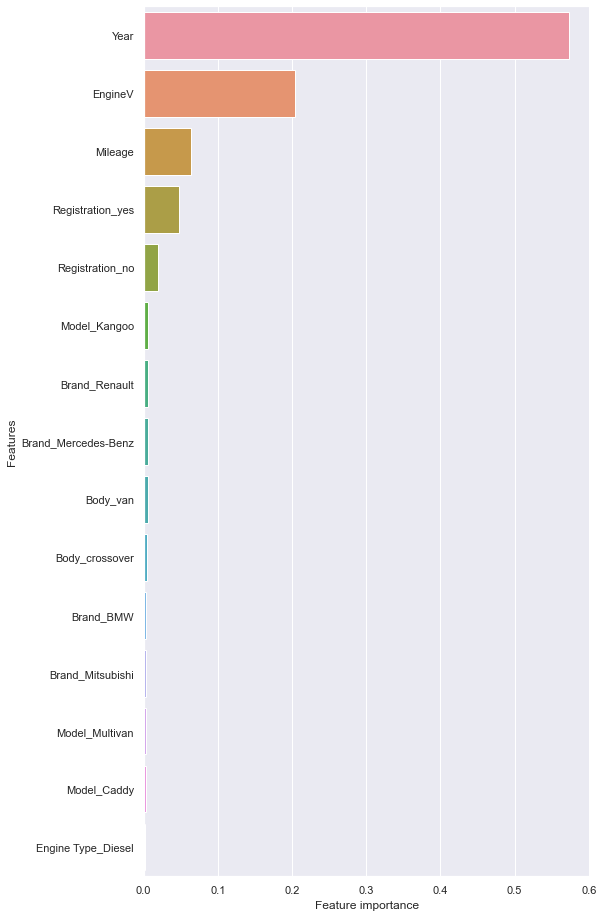

In [186]:
plt.figure(figsize=(8,16))
sns.barplot(x = 'Feature importance', y = 'Features', data = reg_summary.sort_values(['Feature importance'], ascending=False)[:15])

This plot shows the top 15 feature importances. As can be seen, the age of a car is by far the strongest indicator of its value.

In [130]:
y_test = y_test.reset_index(drop=True)
predictions = pd.DataFrame(np.exp(y_hat_test), columns=['Prediction'])
predictions['Target'] = np.exp(y_test)
predictions['Residuals'] = predictions['Target'] - predictions['Prediction']
predictions['% Difference'] = np.absolute(predictions['Residuals']/predictions['Target']*100)

predictions

,Prediction,Target,Residuals,% Difference
0,12824.031350,10800.0,-2024.031350,18.741031
1,40380.591540,40500.0,119.408460,0.294836
2,6700.854600,10700.0,3999.145400,37.375191
3,10511.043451,10500.0,-11.043451,0.105176
4,11829.466802,9600.0,-2229.466802,23.223613
...,...,...,...,...
769,43681.424341,40800.0,-2881.424341,7.062315
770,8612.236180,8100.0,-512.236180,6.323903
771,8499.087545,6500.0,-1999.087545,30.755193
772,23004.722989,24996.0,1991.277011,7.966383


In [131]:
predictions.describe()

,Prediction,Target,Residuals,% Difference
count,774.000000,774.000000,774.000000,774.000000
mean,18572.245915,18851.310736,279.064821,16.222036
std,19528.339180,20020.440882,4462.660815,29.309155
min,1578.070298,1389.000000,-23602.954768,0.021018
25%,7426.840209,7200.000000,-1044.669745,4.131111
50%,11627.912088,11525.000000,10.609569,9.776543
75%,21512.899067,22900.000000,1341.222546,19.778284
max,121755.224888,125000.000000,42997.183453,495.040002


In [161]:
predictions['% Difference'].quantile(0.90)

32.97038157631918

This unoptimized model predicts prices to within 33% accuracy for 90% of the test data, and within 20% for 75% of the test data.